# 3. American Put：Binomial Tree

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def american_put_binomial(S0, X, r, sigma, T, n, q):
    np.random.seed(42)
    t_ = T / n
    u = np.exp(sigma * np.sqrt(t_))
    d = 1 / u
    p = (np.exp((r - q) * t_) - d) / (u - d)

    opt_val = np.zeros(n + 1)
    for j in range(n + 1):
        S_T = S0 * (u ** j) * (d ** (n - j))
        opt_val[j] = max(X - S_T, 0)

    early_ex_boundary = []
    early_ex_boundary.append((T, X))

    for i in range(n-1, -1, -1):
        current_time = i * t_
        current_opt_val = np.zeros(i + 1)
        current_max_S = -np.inf

        for j in range(i + 1):
            S = S0 * (u ** j) * (d ** (i - j))
            cont_value = np.exp(-r * t_) * (p * opt_val[j+1] + (1 - p) * opt_val[j])
            exercise_value = max(X - S, 0)
            current_opt_val[j] = max(cont_value, exercise_value)

            if exercise_value > cont_value:
                if S > current_max_S:
                    current_max_S = S

        # 记录当前时间步的临界价
        if current_max_S != -np.inf:
            early_ex_boundary.append((current_time, current_max_S))
        else:
            early_ex_boundary.append((current_time, None))

        opt_val = current_opt_val

    early_ex_boundary.sort(key=lambda x: x[0])
    times = []
    boundaries = []
    for t, s in early_ex_boundary:
        if s is not None:
            times.append(t)
            boundaries.append(s)

    return opt_val[0], times, boundaries

In [2]:
price, times, boundaries = american_put_binomial(S0=1, X=1, r=0.03, sigma=0.3, T=1, n=10000, q=0)
print(f"American Put Option Price: {price:.4f}")

American Put Option Price: 0.1061


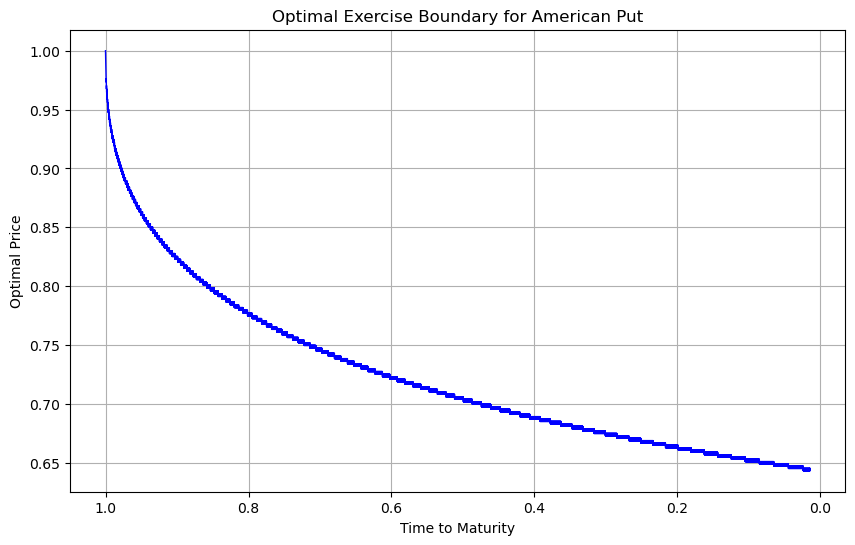

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(times, boundaries, color = 'b', linewidth = 1)
plt.xlabel('Time to Maturity')
plt.ylabel('Optimal Price')
plt.title('Optimal Exercise Boundary for American Put')
plt.gca().invert_xaxis()  
plt.grid(True)
plt.show()

# 5. Asian Call: M-C

In [4]:
def asian_call_monte_carlo(S0, X, r, sigma, T, n_steps, num_sims, seed=None):

    if seed is not None:
        np.random.seed(seed)  
    
    dt = T / n_steps  
    drift = (r - 0.5 * sigma**2) * dt  
    vol = sigma * np.sqrt(dt)  
    
    rand = np.random.normal(0, 1, (num_sims // 2, n_steps))
    rand = np.vstack([rand, -rand])  # 对偶变量
    
    returns = np.exp(drift + vol * rand)
    paths = S0 * np.cumprod(np.hstack([np.ones((num_sims, 1)), returns]), axis=1)
    
    avg_prices = paths[:, 1:].mean(axis=1)
    
    payoffs = np.maximum(avg_prices - X, 0)
    price = np.exp(-r * T) * payoffs.mean()
    
    return price

In [5]:
params = {
    "S0": 1.0,     
    "X": 1.0,      
    "r": 0.03,    
    "sigma": 0.3,  
    "T": 1.0,     
    "n_steps": 252,
    "num_sims": 100000,  
    "seed": 42    
}

price = asian_call_monte_carlo(**params)

print(f"Asian Call Option Price: {price:.4f}")

Asian Call Option Price: 0.0753


# 6. Lookback Call: Binomial Tree

In [6]:
def floating_strike_lookback_call(S0, r, sigma, T, n_steps):

    dt = T / n_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    tree = [[{} for _ in range(i+1)] for i in range(n_steps+1)]
    
    tree[0][0][(S0, S0)] = 0.0  
    
    for i in range(n_steps):
        for j in range(i+1):
            current_states = tree[i][j]
            for (S, m), _ in current_states.items():
                S_up = S * u
                m_up = min(m, S_up)
                up_node = tree[i+1][j+1]
                if (S_up, m_up) not in up_node:
                    up_node[(S_up, m_up)] = 0.0
                
                S_down = S * d
                m_down = min(m, S_down)
                down_node = tree[i+1][j]
                if (S_down, m_down) not in down_node:
                    down_node[(S_down, m_down)] = 0.0
    
    for j in range(n_steps+1):
        node = tree[n_steps][j]
        for (S, m) in node.keys():
            node[(S, m)] = max(S - m, 0)
    
    for i in range(n_steps-1, -1, -1):
        for j in range(i+1):
            current_node = tree[i][j]
            for (S, m) in list(current_node.keys()):  # 避免字典大小变化错误
                
                S_up = S * u
                m_up = min(m, S_up)
                up_node = tree[i+1][j+1]
                value_up = up_node.get((S_up, m_up), 0.0)
                
                S_down = S * d
                m_down = min(m, S_down)
                down_node = tree[i+1][j]
                value_down = down_node.get((S_down, m_down), 0.0)
                
                current_value = (p * value_up + (1-p) * value_down) * np.exp(-r * dt)
                current_node[(S, m)] = current_value
    
    # 根节点的价值即为期权价格
    option_price = tree[0][0].get((S0, S0), 0)
    return option_price


In [7]:
params = {
    "S0": 1,     
    "r": 0.03,     
    "sigma": 0.3,  
    "T": 1,      
    "n_steps": 100       
}

price = floating_strike_lookback_call(**params)
print(f"Lookback Call Price: {price:.4f}")

Lookback Call Price: 0.2185
